<a href="https://colab.research.google.com/github/JaimeLopezGarrido/DMA_Trabajo_Final/blob/main/Ej10_Opcion1_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejercicio 10 - Opción 1 Clasificación**

- Materia: Data Mining Avanzado
- Docente: Martin Volpacchio
- Alumnos: Lucía Pereyra Huertas, Gabriel Martina, Jaime López Garrido, Diego Farfán y Analía Ale


# **Introducción**

Este cuaderno corresponde al Ejercicio 10, Opción 1, del Trabajo Final de la materia Data Mining Avanzado. Su objetivo principal es abordar un problema de clasificación utilizando un dataset publico obtenido de internet, en este caso seleccionamos uno referido al diagnóstico de cáncer de mama. A lo largo del cuaderno se implementan y comparan diferentes modelos de clasificación, tanto clásicos como basados en aprendizaje automático avanzado, incluyendo Support Vector Machine (SVC), Random Forest, Gradient Boosting y un Multi-Layer Perceptron (MLP) implementado de forma manual. Se presentan todas las etapas del flujo de trabajo: preprocesamiento de datos, división en conjuntos de entrenamiento y prueba, entrenamiento de los modelos, predicciones, evaluación mediante métricas como Accuracy, Reporte de Clasificación, Matriz de Confusión y Curva ROC con AUC. Este cuaderno se centra exclusivamente en clasificación, la parte de regresión se trabaja de forma separada en otro cuaderno.

# Librerias

Carga condicional de librerias necesarias para poder correr el codigo completo. Este mecanismo permite que el notebook pueda ejecutarse en cualquier entorno sin necesidad de instalar manualmente cada una de ellas.

In [ ]:
import importlib
import subprocess
import sys

def require(install_name, import_name=None):
    if import_name is None:
        import_name = install_name

    try:
        importlib.import_module(import_name)
        print(f"{import_name} ya está instalado.")
    except ImportError:
        print(f"Instalando {install_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", install_name])
    finally:
        globals()[import_name] = importlib.import_module(import_name)

require("pandas")
require("numpy")
require("scikit-learn", "sklearn")
require("matplotlib")
require("seaborn")

import pandas as pd
import numpy as np
import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay,
    accuracy_score,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns

pandas ya está instalado.
numpy ya está instalado.
sklearn ya está instalado.
matplotlib ya está instalado.
seaborn ya está instalado.


#Dataset



Se selecciono el dataset publico "Breast Cancer Wisconsin (Diagnostic) Dataset". El conjunto de datos fue originalmente publicado en el UCI Machine Learning Repository y contiene mediciones numéricas obtenidas a partir de imágenes médicas de aspiraciones con aguja fina (FNA) de tumores mamarios.

Está compuesto por 569 observaciones y 33 columnas, donde cada fila representa un paciente y cada columna corresponde a una característica cuantitativa extraída de los núcleos celulares observados en las imágenes. Estas características describen propiedades como el radio, la textura, el perímetro, el área, la suavidad y la concavidad, entre otras, calculadas en diferentes formas (media, error estándar y peor valor).

La variable objetivo es la columna diagnosis, que define un problema de clasificación binaria:

- M: tumor maligno

- B: tumor benigno

El objetivo del análisis es construir un modelo capaz de clasificar correctamente nuevos casos como benignos o malignos a partir de las variables predictoras disponibles.

El dataset se obtiene directamente desde un repositorio público en línea en formato CSV, lo que garantiza la reproducibilidad del experimento y permite ejecutar el código sin necesidad de descargas manuales.

In [ ]:
# Dataset de CLASIFICACIÓN (Breast Cancer Wisconsin)
url_clasificacion = "https://huggingface.co/datasets/mnemoraorg/wisconsin-breast-cancer-diagnostic/resolve/main/raw_breast_cancer.csv"
dataset_c = pd.read_csv(url_clasificacion)

# Exploración inicial Clasificación

print("DATASET CLASIFICACIÓN")
print("Dimensiones:", dataset_c.shape)
print("\nColumnas:\n")
print(dataset_c.columns)
print("\nTipos de datos:\n")
print(dataset_c.dtypes)
print("\nValores faltantes por columna:\n")
print(dataset_c.isnull().sum())
print("\nPrimeras filas:\n")
display(dataset_c.head())
print("\nUltimas filas:\n")
display(dataset_c.tail())
print("\nResumen estadístico:\n")
display(dataset_c.describe(include="all"))

DATASET CLASIFICACIÓN
Dimensiones: (569, 33)

Columnas:

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

Tipos de datos:

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mea

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN



Ultimas filas:



,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN
568,92751,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,NaN



Resumen estadístico:



,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.037183e+07,NaN,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,NaN,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,NaN,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,NaN,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,NaN,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,NaN,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN


# Preprocesamiento

In [ ]:
# Se eliminan columnas que no aportan información al modelo
# id por ser identificador y unnamed por estar vacia
dataset_c = dataset_c.drop(columns=["id", "Unnamed: 32"])

# Se determina la variable objetivo. Se la pasa a numerica por facilidad de calculos
y = dataset_c["diagnosis"].map({'M': 1, 'B': 0})

# Variables predictoras
X = dataset_c.drop(columns=["diagnosis"])



División en conjuntos de entrenamiento y prueba.

En este caso se decide dividir en un 75% entrenamiento y un 25% restante para prueba.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

print(y_train.unique())
print(y_test.unique())

[0 1]
[1 0]




---
##**Support Vector Classifier (SVC)**


Escalamos los datos y usamos GridSearch para afinar los parámetros C y gamma, buscando maximizar el ROC AUC. Se podra ver que para todos los casos, una vez elegido el mejor modelo, lo pusimos a prueba revisando la matriz de confusión y el reporte de clasificación para entender bien cómo se comportaba con cada clase.

###Pipeline:

In [ ]:
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', probability=True, random_state=42))
])

param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': ['scale', 0.01, 0.1, 1]
}

grid = GridSearchCV(pipeline_svm, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)


print(f"\nMejores parámetros encontrados: {grid.best_params_}")
print(f"Mejor ROC AUC en validación cruzada: {grid.best_score_:.4f}")
print(f"Accuracy en Test set con el mejor modelo: {grid.score(X_test, y_test):.4f}")



Fitting 5 folds for each of 16 candidates, totalling 80 fits

Mejores parámetros encontrados: {'clf__C': 100, 'clf__gamma': 0.01}
Mejor ROC AUC en validación cruzada: 0.9960
Accuracy en Test set con el mejor modelo: 0.9908


## Evaluacion

Accuracy en prueba: 0.9580

Reporte de Clasificación:

              precision    recall  f1-score   support

     Benigno       0.96      0.98      0.97        90
     Maligno       0.96      0.92      0.94        53

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



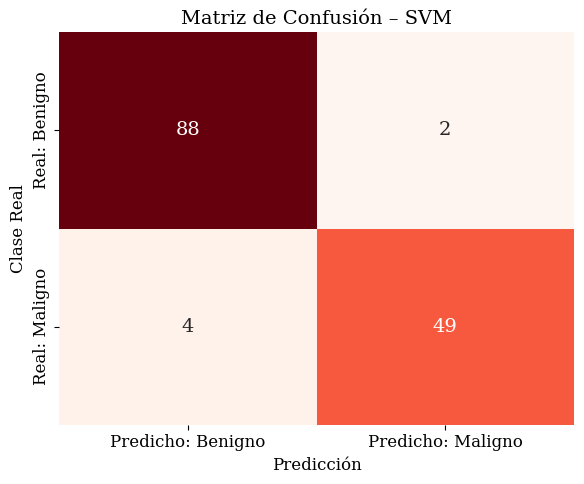

In [ ]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12
})

best_model = grid.best_estimator_

# Predicciones sobre el set de prueba
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]


print(f'Accuracy en prueba: {best_model.score(X_test, y_test):.4f}')
print('\nReporte de Clasificación:\n')
print(classification_report(y_test, y_pred, target_names=['Benigno', 'Maligno']))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Reds',
    cbar=False,
    xticklabels=['Predicho: Benigno', 'Predicho: Maligno'],
    yticklabels=['Real: Benigno', 'Real: Maligno'],
    annot_kws={"size": 14}
)

plt.title('Matriz de Confusión – SVM', fontsize=14)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Clase Real', fontsize=12)
plt.tight_layout()
plt.show()

Área Bajo la Curva (AUC) en prueba: 0.9908


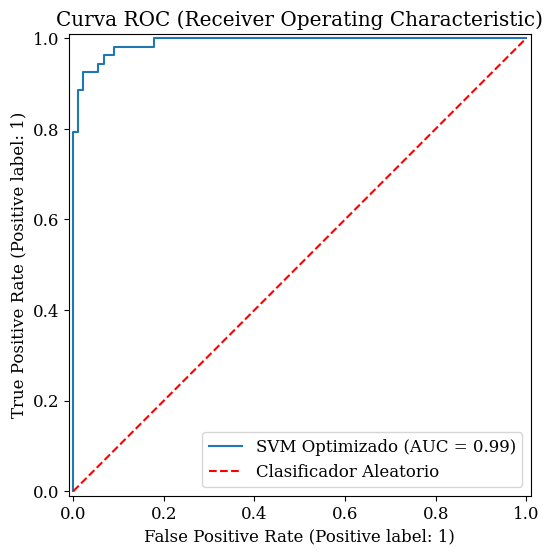

In [ ]:
# Curva ROC
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f'Área Bajo la Curva (AUC) en prueba: {roc_auc:.4f}')


plt.figure(figsize=(8, 6))

RocCurveDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    name="SVM Optimizado",
    ax=plt.gca()
)

plt.plot([0, 1], [0, 1], 'r--', label='Clasificador Aleatorio')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend()
plt.show()

---
# Multi-Layer Perceptron (Manual)

Lo programamos "a mano" para entender mejor cómo funciona por dentro, así que esta vez no usamos la búsqueda automática de parámetros, lo que si hicimos fue probarlo exactamente con los mismos datos que usamos en los otros modelos. Lo entrenamos durante varias épocas vigilando que el error bajara para asegurar que convergía. No se toma para la comparacion final de modelos.

In [ ]:
# Escalado de variables para no tener errores por diferencias en las escalas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Funciones de activacion: sigmoide, relu
def sigmoid_act(x, der=False):
    if der:
        return x * (1 - x)   # x es la salida
    return 1 / (1 + np.exp(-x))

def relu_act(x, der=False):
    if der:
        return (x > 0).astype(float)
    return np.maximum(0, x)

### Entrenamiento

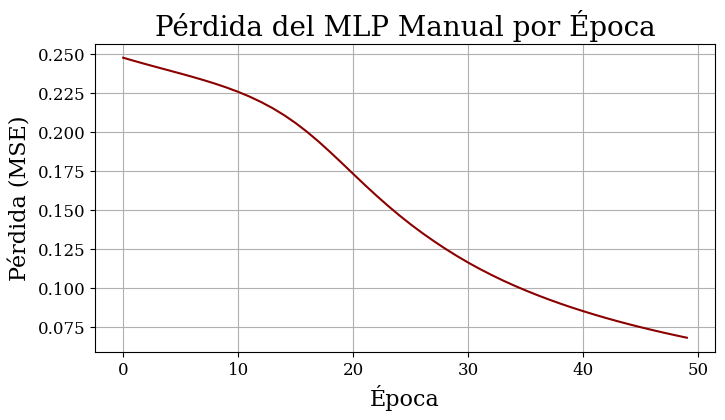

In [ ]:
# Funciones auxiliares
def forward_pass(x, params):
    h1 = relu_act(np.dot(params["W1"], x) + params["b1"])
    h2 = relu_act(np.dot(params["W2"], h1) + params["b2"])
    out = sigmoid_act(np.dot(params["Wout"], h2) + params["bout"])
    return h1, h2, out


def backward_pass(x, y_true, h1, h2, y_pred, params, lr):
    error = y_pred - y_true
    delta_out = 2 * error * y_pred * (1 - y_pred)

    delta_h2 = delta_out * params["Wout"] * relu_act(h2, der=True)
    delta_h1 = np.dot(params["W2"].T, delta_h2) * relu_act(h1, der=True)

    params["Wout"] -= lr * delta_out * h2
    params["bout"] -= lr * delta_out

    params["W2"] -= lr * np.outer(delta_h2, h1)
    params["b2"] -= lr * delta_h2

    params["W1"] -= lr * np.outer(delta_h1, x)
    params["b1"] -= lr * delta_h1


# Entrenamiento del MLP
def train_manual_ann(X_train, y_train, p, q, eta, epochs):
    n_features = X_train.shape[1]

    params = {
        "W1": np.random.randn(p, n_features) * 0.1,
        "b1": np.zeros(p),
        "W2": np.random.randn(q, p) * 0.1,
        "b2": np.zeros(q),
        "Wout": np.random.randn(q) * 0.1,
        "bout": np.zeros(1)
    }

    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0

        for x, y in zip(X_train, y_train):
            h1, h2, y_pred = forward_pass(x, params)
            epoch_loss += (y_pred - y) ** 2
            backward_pass(x, y, h1, h2, y_pred, params, eta)

        loss_history.append(epoch_loss / len(X_train))

    return params, loss_history

# Hiperparámetros puestos "a mano"
p = 10
q = 5
eta = 0.001
epochs = 50

# Entrenamiento
manual_weights, manual_loss = train_manual_ann(
    X_train_scaled,
    y_train.values,
    p,
    q,
    eta,
    epochs
)

# Gráfico de pérdida
plt.figure(figsize=(8, 4))
plt.plot(manual_loss, color="darkred")
plt.title("Pérdida del MLP Manual por Época", fontsize=20)
plt.xlabel("Época", fontsize=16)
plt.ylabel("Pérdida (MSE)", fontsize=16)
plt.grid(True)
plt.show()

Se utilizaron 50 épocas, pero se observó que 20 eran suficientes para este caso en particular.

In [ ]:
# Predicción
def predict_manual_ann(X, params, proba=False):
    outputs = []

    for x in X:
        _, _, y_hat = forward_pass(x, params)
        outputs.append(y_hat[0])

    outputs = np.array(outputs)

    if proba:
        return outputs

    return (outputs >= 0.5).astype(int)


y_pred_manual = predict_manual_ann(X_test_scaled, manual_weights)
y_proba_manual = predict_manual_ann(X_test_scaled, manual_weights, proba=True)


# Evaluación
print(f"Accuracy en Test (MLP Manual): {accuracy_score(y_test, y_pred_manual):.4f}")
print("\nReporte de Clasificación:\n")
print(classification_report(y_test, y_pred_manual, target_names=["Benigno", "Maligno"]))


Accuracy en Test (MLP Manual): 0.9580

Reporte de Clasificación:

              precision    recall  f1-score   support

     Benigno       0.94      1.00      0.97        90
     Maligno       1.00      0.89      0.94        53

    accuracy                           0.96       143
   macro avg       0.97      0.94      0.95       143
weighted avg       0.96      0.96      0.96       143



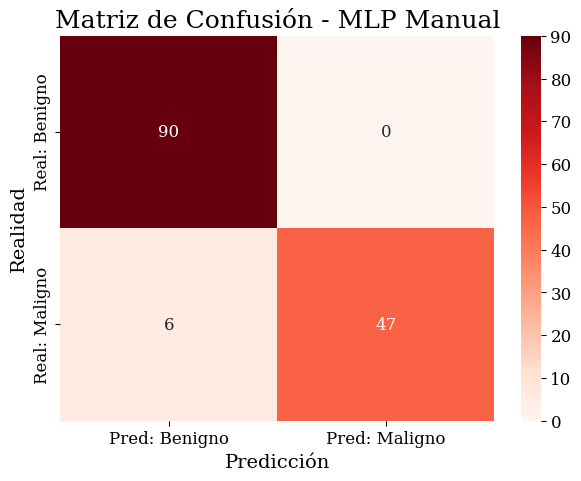

In [ ]:
# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_manual)

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Pred: Benigno", "Pred: Maligno"],
    yticklabels=["Real: Benigno", "Real: Maligno"]
)
plt.title("Matriz de Confusión - MLP Manual", fontsize=18)
plt.xlabel("Predicción", fontsize=14)
plt.ylabel("Realidad", fontsize=14)
plt.show()

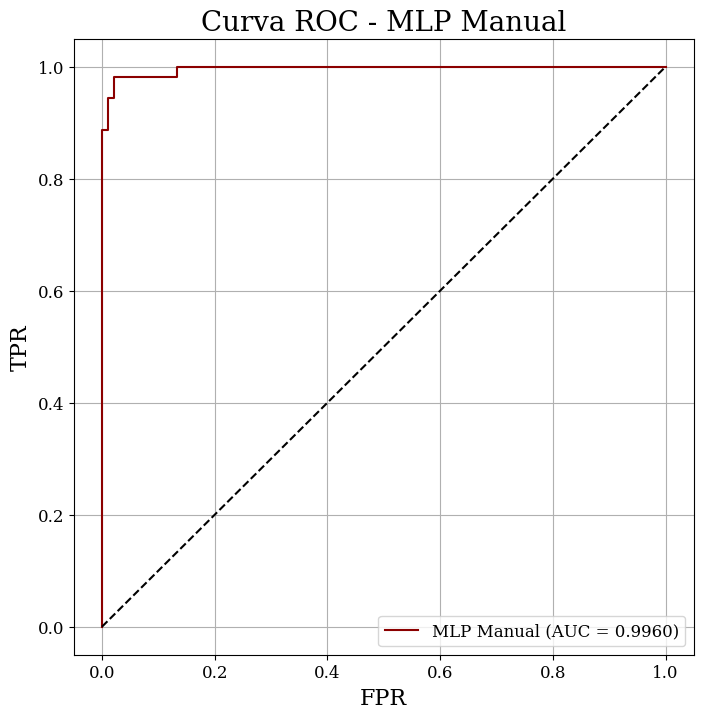

In [ ]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_manual)
roc_auc = roc_auc_score(y_test, y_proba_manual)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color="darkred", label=f"MLP Manual (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Curva ROC - MLP Manual", fontsize=20)
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

---
# Multi-Layer Perceptron


Ahora si se usó la implementación de scikit-learn y se integró al pipeline con GridSearch y validación cruzada, siguiendo la misma forma de trabajo que con el resto de los modelos. Es la opcion que se toma para la comparacion final de modelos.

In [ ]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        max_iter=1000,
        random_state=42
    ))
])

# Hiperparámetros
param_grid_mlp = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (50, 50)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [0.0001, 0.001, 0.01],
    "mlp__learning_rate": ["constant", "adaptive"]
}

# GridSearch con validación cruzada
grid_mlp = GridSearchCV(
    mlp_pipeline,
    param_grid_mlp,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

# Entrenamiento
grid_mlp.fit(X_train, y_train)

best_mlp = grid_mlp.best_estimator_

print("Mejores hiperparámetros MLP:", grid_mlp.best_params_)
print(f"Mejor ROC AUC (CV): {grid_mlp.best_score_:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros MLP: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate': 'constant'}
Mejor ROC AUC (CV): 0.9956


In [ ]:
# Predicciones
y_pred_mlp = best_mlp.predict(X_test)
y_proba_mlp = best_mlp.predict_proba(X_test)[:, 1]

# Métricas
print(f"Accuracy en Test (MLP): {accuracy_score(y_test, y_pred_mlp):.4f}")
print("\nReporte de Clasificación:\n")
print(classification_report(
    y_test,
    y_pred_mlp,
    target_names=["Benigno", "Maligno"]
))

Accuracy en Test (MLP): 0.9650

Reporte de Clasificación:

              precision    recall  f1-score   support

     Benigno       0.95      1.00      0.97        90
     Maligno       1.00      0.91      0.95        53

    accuracy                           0.97       143
   macro avg       0.97      0.95      0.96       143
weighted avg       0.97      0.97      0.96       143



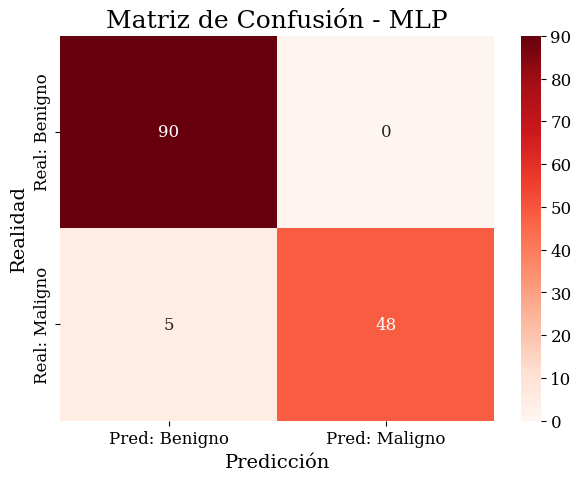

In [ ]:
# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_mlp)

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Pred: Benigno", "Pred: Maligno"],
    yticklabels=["Real: Benigno", "Real: Maligno"]
)
plt.title("Matriz de Confusión - MLP", fontsize=18)
plt.xlabel("Predicción", fontsize=14)
plt.ylabel("Realidad", fontsize=14)
plt.show()

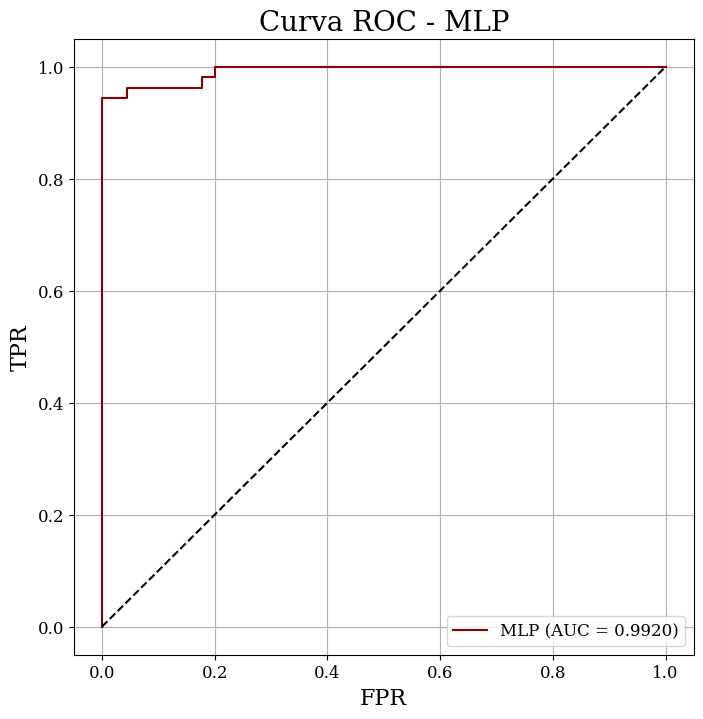

In [ ]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_mlp)
roc_auc = roc_auc_score(y_test, y_proba_mlp)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color="darkred", label=f"MLP (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Curva ROC - MLP", fontsize=20)
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

---

# **Random Forest**

Aunque Random Forest no requiere de escalado, se incluye dentro del pipeline para mantener una estructura homogénea entre modelos. Se realizo un GridSearch probando distinta cantidad de árboles y profundidad para encontrar la mejor configuración.

In [ ]:
# Pipeline con preprocesamiento
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
    ))
])

# Random Forest con GridSearch y k-fold Cross-Validation
param_grid_rf = {
    "rf__n_estimators": [100, 200, 400],
    "rf__max_depth": [None, 5, 10, 20],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4]
}

grid_rf = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

print("Mejores hiperparámetros RF:", grid_rf.best_params_)
print(f"Mejor ROC AUC (CV): {grid_rf.best_score_:.4f}")

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluación
print(f"Accuracy en Test (Random Forest): {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nReporte de Clasificación:\n")
print(classification_report(
    y_test,
    y_pred_rf,
    target_names=["Benigno", "Maligno"]
))



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiperparámetros RF: {'rf__max_depth': 5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Mejor ROC AUC (CV): 0.9911
Accuracy en Test (Random Forest): 0.9650

Reporte de Clasificación:

              precision    recall  f1-score   support

     Benigno       0.95      1.00      0.97        90
     Maligno       1.00      0.91      0.95        53

    accuracy                           0.97       143
   macro avg       0.97      0.95      0.96       143
weighted avg       0.97      0.97      0.96       143



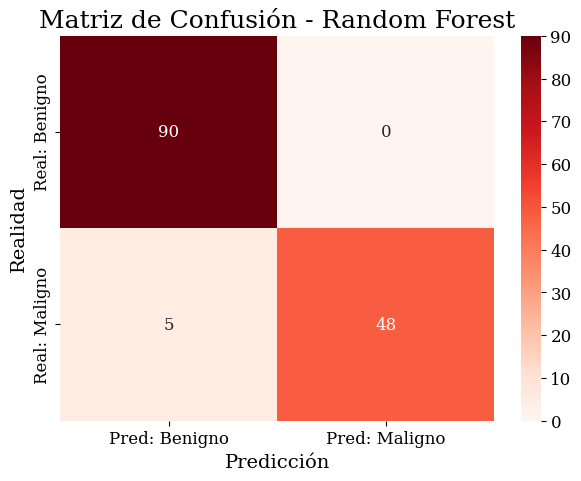

In [ ]:
# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Pred: Benigno", "Pred: Maligno"],
    yticklabels=["Real: Benigno", "Real: Maligno"]
)
plt.title("Matriz de Confusión - Random Forest", fontsize=18)
plt.xlabel("Predicción", fontsize=14)
plt.ylabel("Realidad", fontsize=14)
plt.show()

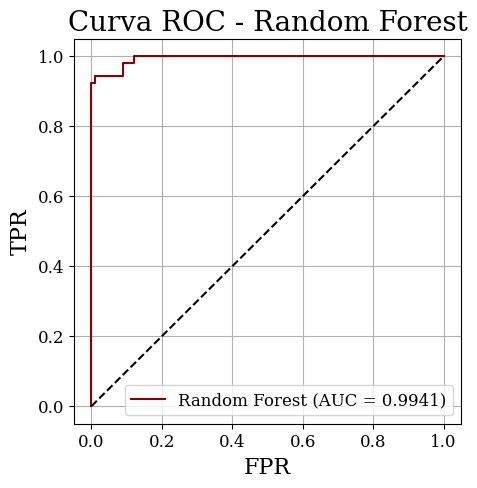

In [ ]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = roc_auc_score(y_test, y_proba_rf)

plt.figure(figsize=(5, 5))
plt.plot(
    fpr,
    tpr,
    color="darkred",
    label=f"Random Forest (AUC = {roc_auc:.4f})"
)
plt.plot([0, 1], [0, 1], "k--")
plt.title("Curva ROC - Random Forest", fontsize=20)
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

---

# **Gradient Boosting**

Aunque Gradient Boosting no requiere de escalado, se incluye dentro del pipeline para mantener una estructura homogénea entre modelos. Se corrio el modelo ajustando con GridSearch la cantidad de árboles y qué tan rápido aprende el modelo.

In [ ]:
gb_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

# Gradient Boosting con GridSearch y k-fold Cross-Validation
param_grid_gb = {
    "gb__n_estimators": [100, 200, 300],
    "gb__learning_rate": [0.01, 0.05, 0.1],
    "gb__max_depth": [2, 3, 4]
}

grid_gb = GridSearchCV(
    gb_pipeline,
    param_grid_gb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_gb.fit(X_train, y_train)

best_gb = grid_gb.best_estimator_

print("Mejores hiperparámetros GB:", grid_gb.best_params_)
print(f"Mejor ROC AUC (CV): {grid_gb.best_score_:.4f}")

y_pred_gb = best_gb.predict(X_test)
y_proba_gb = best_gb.predict_proba(X_test)[:, 1]

# Accuracy y reporte de clasificación
print(f"Accuracy en Test (Gradient Boosting): {accuracy_score(y_test, y_pred_gb):.4f}")
print("\nReporte de Clasificación:\n")
print(classification_report(y_test, y_pred_gb, target_names=["Benigno", "Maligno"]))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros GB: {'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__n_estimators': 300}
Mejor ROC AUC (CV): 0.9917
Accuracy en Test (Gradient Boosting): 0.9650

Reporte de Clasificación:

              precision    recall  f1-score   support

     Benigno       0.95      1.00      0.97        90
     Maligno       1.00      0.91      0.95        53

    accuracy                           0.97       143
   macro avg       0.97      0.95      0.96       143
weighted avg       0.97      0.97      0.96       143



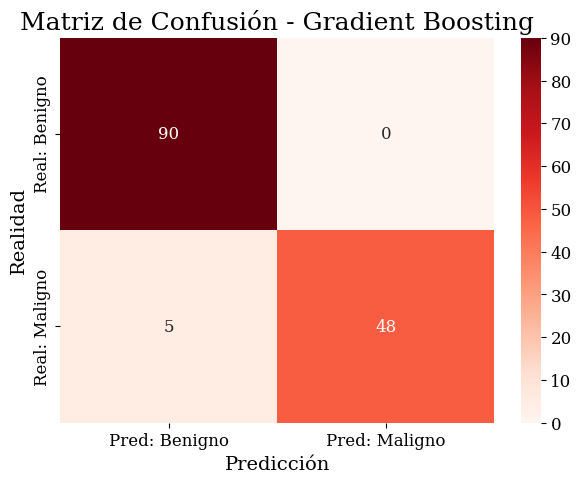

In [ ]:
# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(7, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Reds",
    xticklabels=["Pred: Benigno", "Pred: Maligno"],
    yticklabels=["Real: Benigno", "Real: Maligno"]
)
plt.title("Matriz de Confusión - Gradient Boosting", fontsize=18)
plt.xlabel("Predicción", fontsize=14)
plt.ylabel("Realidad", fontsize=14)
plt.show()

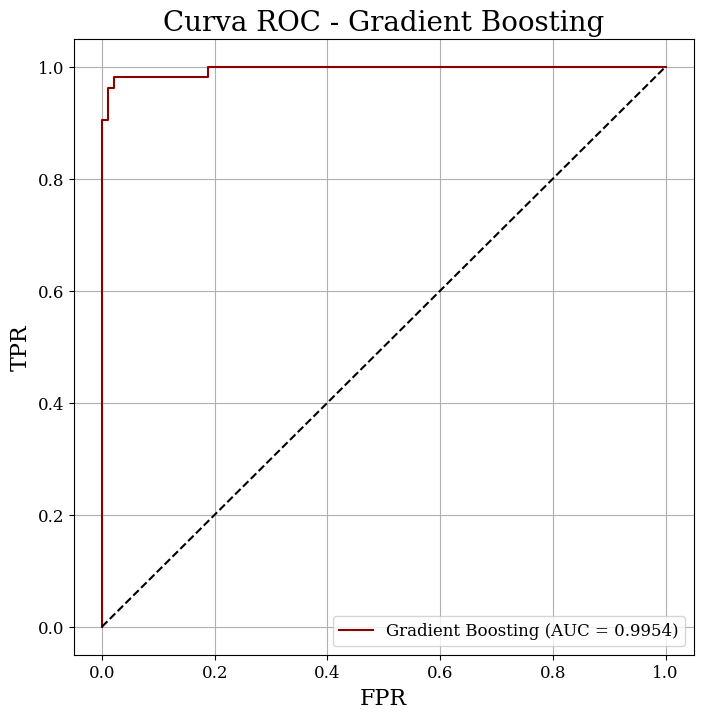

In [ ]:
# Curva ROC y AUC
fpr, tpr, _ = roc_curve(y_test, y_proba_gb)
roc_auc = roc_auc_score(y_test, y_proba_gb)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color="darkred", label=f"Gradient Boosting (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Curva ROC - Gradient Boosting", fontsize=20)
plt.xlabel("FPR", fontsize=16)
plt.ylabel("TPR", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

---
# Comparacion de Modelos

El modelo manual de Multi-Layer Perceptron fue dejado de lado

In [ ]:
# Comparación final de modelos
modelos = {
    "SVM": best_model,
    "Random Forest": best_rf,
    "Gradient Boosting": best_gb,
    "MLP": best_mlp
}

resultados = []

for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:, 1]

    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

df_resultados = pd.DataFrame(resultados)
display(df_resultados)

,Modelo,Accuracy,ROC AUC
0,SVM,0.958042,0.990776
1,Random Forest,0.965035,0.994130
2,Gradient Boosting,0.965035,0.995388
3,MLP,0.965035,0.992034


/tmp/ipython-input-2818173942.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


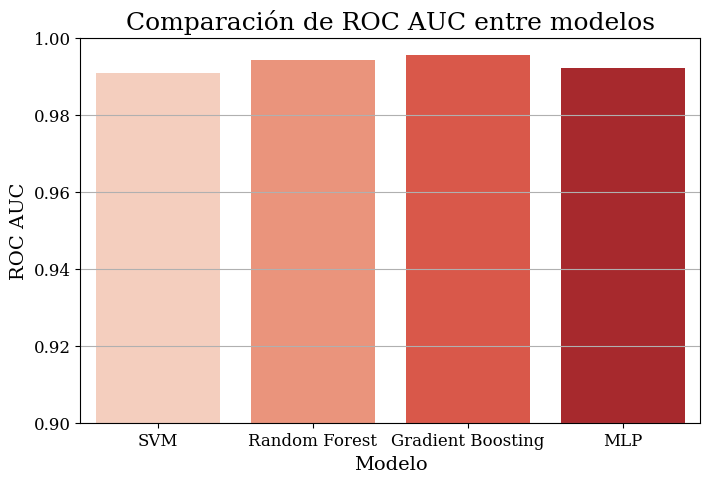

In [ ]:
# Comparacion ROC AUC
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_resultados,
    x="Modelo",
    y="ROC AUC",
    palette="Reds"
)

plt.title("Comparación de ROC AUC entre modelos", fontsize=18)
plt.xlabel("Modelo", fontsize=14)
plt.ylabel("ROC AUC", fontsize=14)
plt.ylim(0.9, 1.0)
plt.grid(axis="y")
plt.show()

In [ ]:
df_resultados.sort_values("ROC AUC", ascending=False)

,Modelo,Accuracy,ROC AUC
2,Gradient Boosting,0.965035,0.995388
1,Random Forest,0.965035,0.994130
3,MLP,0.965035,0.992034
0,SVM,0.958042,0.990776


En este cuaderno se completó la parte de clasificación del Ejercicio 10 utilizando el dataset de Breast Cancer. Se realizó el flujo de trabajo completo, desde la preparación de los datos hasta el ajuste de parámetros con GridSearch y validación cruzada, comparando cuatro modelos: SVM, Random Forest, Gradient Boosting y MLP.

Los resultados fueron muy parejos: Gradient Boosting, Random Forest y MLP empataron en Accuracy. Sin embargo, el Gradient Boosting quedó primero por una mínima diferencia en el ROC AUC. El SVM también rindió muy bien, quedando apenas por detrás. En resumen, todos los modelos mostraron ser muy sólidos para este problema, dejando el camino listo para pasar a la parte de regresión.